# Try out prospect theroy (PV) for investor decision making

Each investor has the choice to either `sell`, `rent`, or `wait` each `housing_unit` they own. 

## Set up the initial variables 

<AxesSubplot:>

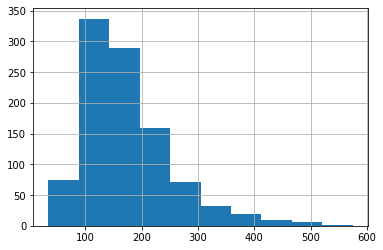

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import random 

df = pd.DataFrame()

prices = gpd.read_file('prices.geojson')

housing_unit_count = 1000
discount_factor_corporate_average = 0.9
discount_factor_corporate_std = 0.05
discount_factor_amateur_average = 0.8
discount_factor_amateur_std = 0.05

tax_vacancy = 0.01
tax_property = 0.01

price_samples = prices.sample(n=housing_unit_count, replace=True)

# average area is 70m^s, with a standard deviation of 15m^2
df['investor type'] = [random.choice(['amateur', 'corporate']) for i in range(housing_unit_count)]
df['unit area'] = np.random.normal(70, 15, housing_unit_count).astype(int)
df['neighbourhood price per m^2'] = price_samples['2018 price'].to_numpy()
df['price delta'] = price_samples['delta 2017 2018'].to_numpy()
df['price delta'] = df['price delta'].fillna(-83)
df['price delta rate'] = (df['price delta'] / df['neighbourhood price per m^2'].abs())
df['price sale'] = df['unit area'] * df['neighbourhood price per m^2']

df['interest rate'] = np.where(df['investor type'] == 'corporate', 0.07, 0.11)

def subjective(i):
    if i == 'corporate':
        return random.gauss(discount_factor_corporate_average, discount_factor_corporate_std) 
    else:
        return random.gauss(discount_factor_amateur_average, discount_factor_amateur_std)

df['subjective discount factor'] = df.apply(lambda r: subjective(r['investor type']), axis=1)

df['rent share of price'] = np.random.normal(0.004, 0.0005, housing_unit_count)
df['price rent'] = df['rent share of price'] * df['price sale']

df['operating costs share of price'] = np.random.normal(0.0007, 0.00005, housing_unit_count)
df['operating costs'] = df['operating costs share of price'] * df['price sale']

df['mortgage share of price'] = np.where(df['investor type'] == 'corporate', 0.9, 0.1)

# df['subjective discount factor'].hist(bins=100)
# df['neighbourhood price per m^2'].hist()
# df['price delta'].hist()
# df['price delta rate'].hist()
# df['interest rate'].hist()
df['operating costs'].hist()


In [2]:
df.head()

investor type  unit area  neighbourhood price per m^2  price delta  \
0       amateur         40                         2800        200.0   
1     corporate         75                         4200          0.0   
2       amateur         64                         3163       -337.0   
3       amateur         58                         2943         93.0   
4     corporate         76                         2500        -83.0   

   price delta rate  price sale  interest rate  subjective discount factor  \
0          0.071429      112000           0.11                    0.833472   
1          0.000000      315000           0.07                    0.787882   
2         -0.106544      202432           0.11                    0.799037   
3          0.031600      170694           0.11                    0.794148   
4         -0.033200      190000           0.07                    0.939080   

   rent share of price   price rent  operating costs share of price  \
0             0.003964   443.987047                        0.000728   
1             0.004028  1268.867218                        0.000741   
2             0.004621   935.445150                        0.000639   
3             0.004234   722.711358                        0.000670   
4             0.003964   753.200298                        0.000731   

   operating costs  mortgage share of price  
0        81.577858                      0.1  
1       233.429261                      0.9  
2       129.314116                      0.1  
3       114.410435                      0.1  
4       138.933305                      0.9

## Now calculate the rate of return for rent and sale

### Rate of return for rent

The rate of return ($RoR$) is calculated using the following formula: 

$$RoR\; =\; v\; =\; \frac{V}{D}\; =\frac{\delta \left( 1+\dot{p}-\left( 1+r \right)m \right)+\rho -\kappa -t}{1-m}$$

Where the variables are: 

variable | meaning 
-------- | ---
$\delta$ | Sujbective discount factor
$\dot{p}$ | Expected rate of price increase 
$r$ | Interest rate on mortgages 
$m$ | Mortgage as share of price 
$\rho$ | Rent as share of price
$\kappa$ | Operating costs as share of price 
$t$ | taxes (vacancy, property, etc...)

<!---

Here we have four different scenarios: 

tax schema ⬇️ \ action ➡️ | Sell | Rent 
----------------------- | ---- | ----
Tax | $\rho = 0, \kappa = low, t = high$ | $\rho = high, \kappa = high, t = high$
No tax | $\rho = 0, \kappa = low, t = low$ | $\rho = high, \kappa = high, t = low$
--->


array([[<AxesSubplot:title={'center':'rate of return rent no tax'}>,
        <AxesSubplot:title={'center':'rate of return no rent no tax'}>],
       [<AxesSubplot:title={'center':'rate of return rent tax'}>,
        <AxesSubplot:title={'center':'rate of return no rent tax'}>]],
      dtype=object)

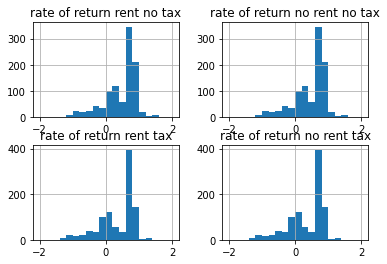

In [3]:
def rate_of_return_rent(r, rent_included=True, taxes=[0.01,0.01]): # r is short for row 
    rent = r['rent share of price'] if rent_included else 0
    v = (r['subjective discount factor'] * (1 + r['price delta rate'] - (1 + r['interest rate'])*r['mortgage share of price']) + \
     r['rent share of price'] - \
     r['operating costs share of price'] - \
     sum(taxes)) / (1 - r['mortgage share of price'])
    return v
    
# with tax scenario 
df['rate of return rent tax'] = df.apply(rate_of_return_rent, axis=1)
df['rate of return no rent tax'] = df.apply(rate_of_return_rent, rent_included=False, axis=1)

# withOUT tax scenario 
df['rate of return rent no tax'] = df.apply(rate_of_return_rent, taxes=[], axis=1)
df['rate of return no rent no tax'] = df.apply(rate_of_return_rent, rent_included=False, taxes=[], axis=1)

# df['rate of return no rent'].describe()
# df['rate of return rent'].describe()
    
df.hist(column=['rate of return rent no tax', 
                'rate of return no rent no tax',
                'rate of return rent tax', 
                'rate of return no rent tax',], 
        range=[-2,2], 
        bins=20)

# Calculate expected value for each investor 

Expected value is defined as 

$$\mbox{EV}=\sum_{i=1}^{n}{p_{i}x_{i}}$$

variable | explanation
-------- | -----------
$x_{i}$ | rate of return at a specific asking price for rent, $\rho$
$p_{i}$ | probability of renting of housing unit at a specific price ($:= \rho * {price}$) within a single time step 

## Expected value for rent 

We assume that an investor gets only once chance to set the price of the housing unit at each time step. So, there are two possible outcomes: either the unit is rented at the asking price, or it is not. 

outcome | explanation
------- | -----------
$x_{1}$ | unit is rented at $\rho$
$x_{2}$ | no renter agreed to rent at $\rho$

To find the probabilities associated with $x_{1}$ and $x_{2}$, we have to rely on historical data. So let's fake some historical data. 






### Generate historical data 

We don't really know what is the distribution of the sale of units is like. One paper Arnott (1989) describes the arrival and departure of households from the market as having a poisson distribution. For now, we assume that this is true. 

The temporal resolution that I'm assuming here is that 1 time step = 3 months. 

<AxesSubplot:>

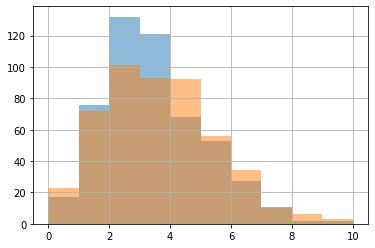

In [4]:
history = pd.DataFrame()

price_samples = prices.sample(n=housing_unit_count, replace=True)

# average area is 70m^s, with a standard deviation of 15m^2
history['unit area'] = np.random.normal(70, 15, housing_unit_count).astype(int)
history['neighbourhood price per m^2'] = price_samples['2018 price'].to_numpy()
history['sale price'] = history['unit area'] * history['neighbourhood price per m^2']
history['rent share of price'] = np.random.normal(0.004, 0.0005, housing_unit_count)
history['rent price'] = history['rent share of price'] * history['sale price']
history['rent price'] = history['rent price'].astype(int)
history['market'] = [random.choice(['rent', 'sale']) for i in range(housing_unit_count)]
history['time steps on market'] = np.random.poisson(3, housing_unit_count)


history.head()

history.query('`market` == "sale"')['time steps on market'].hist(alpha=0.5, label='sale', range=[0,10], bins=10)
history.query('`market` == "rent"')['time steps on market'].hist(alpha=0.5, label='rent', range=[0,10], bins=10)

# history['time steps on market'].hist(leg=, alpha=0.5)

# Get probability from the `history` series

Arnott describes the housing market as a thin market. He describes it as follows: 

> Housing vacancies can be derived from three intrinsic characteristics of housing: (1) multidimensional heterogeneity of the product; (2) indivisibility (households cannot purchase fractions of different units and combine these fractions to obtain their ideal unit); and (3) multidimensional heterogeneity of household tastes. These three characteristics of housing combine to render the housing market thin; even though there are many housing units, the dimensionality of the characteristics space for housing is so high that the units are sparse in this space.

When we stratify the historical data by class, we will see that reflected. 



<AxesSubplot:>

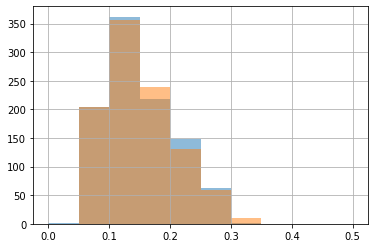

In [5]:
from scipy.stats import poisson

def probability_of_rent(housing_unit):
    asking_price = housing_unit['price rent'] * (1+housing_unit['price delta rate']) # should we include an optimism factor?  
    sampled = history.iloc[(history['rent price']-asking_price).abs().argsort()[:10]]
    p_lambda = sampled['time steps on market'].mean()
    return poisson.pmf(1, p_lambda) # probabilty of renting a unit out after 1 time step (3 months)


def probability_of_sale(housing_unit):
    asking_price = housing_unit['price sale'] * (1+housing_unit['price delta rate']) # should we include an optimism factor?  
    sampled = history.iloc[(history['sale price']-asking_price).abs().argsort()[:10]]
    p_lambda = sampled['time steps on market'].mean()
    return poisson.pmf(1, p_lambda) # probabilty of renting a unit out after 1 time step (3 months)


    
df['probability of rent'] = df.apply(probability_of_rent, axis=1)
df['probability of sale'] = df.apply(probability_of_sale, axis=1)

df['probability of rent'].hist(alpha=0.5, range=[0,0.5], bins=10)
df['probability of sale'].hist(alpha=0.5, range=[0,0.5], bins=10)

## Finally calculate the exepcted value!

<AxesSubplot:>

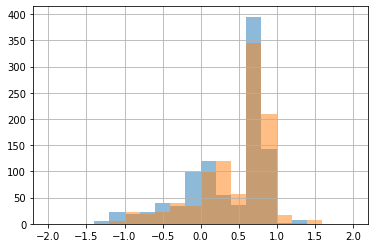

In [6]:
def expected_value_rent_tax(housing_unit):
    return housing_unit['rate of return no rent tax']*(1-housing_unit['probability of rent']) + \
           housing_unit['rate of return rent tax']*(housing_unit['probability of rent'])

def expected_value_rent_no_tax(housing_unit):
    return housing_unit['rate of return no rent no tax']*(1-housing_unit['probability of rent']) + \
           housing_unit['rate of return rent no tax']*(housing_unit['probability of rent'])


df['expected value rent tax'] = df.apply(expected_value_rent_tax, axis=1)
df['expected value rent no tax'] = df.apply(expected_value_rent_no_tax, axis=1)

df['expected value rent tax'].hist(alpha=0.5, range=[-2,2], bins=20)
df['expected value rent no tax'].hist(alpha=0.5, range=[-2,2], bins=20)

### How does expected value compare to Prospect Theory value?

Prospect theory is basically expected value, but with different functions for weighing the (outcome, probability) pairs. It's defined as: 

$$PTV = \sum_{i=1}^{n}{w (p_{i})v (x_{i})}$$

Where $v(x)$ is defined as:

$$ 
v(x) = \begin{cases}
    x^{\alpha } & x \geq 0 \\
    -\lambda (-x^{\beta }) & x \lt 0\\
    \end{cases}
$$

Where $\alpha := 1$, $\beta := 1$, and $\lambda$ is dependant on the type of investor (corporate or amateur). 

And $w(p)$ is function that weighs the probability, where extreme probabilities (near 0 and 1) are overweighed 

$$ 
w(p) = \frac{p^{\gamma}}{(p^{\gamma}+(1-p)^{\gamma})^{{1}/{\gamma}}}
$$

Let's explore the shape of $w(p)$ a bit. We will define $\gamma$ to be around 0.9 for corporate developers, and 0.5 for amateur developers, normally distributed with a variance of 0.01. This assumption is because corporate investors have more systemic ways of evaluating probabilities. 

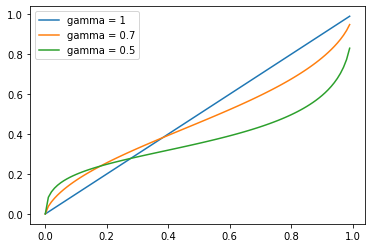

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def weight(p, gamma=1):
    return (p**gamma) / (p**gamma + (1 - p)**gamma)**(1/gamma)

ps = np.arange(0, 1, 0.01)

w_03 = [weight(p, gamma=0.3) for p in ps]
w_05 = [weight(p, gamma=0.5) for p in ps]
w_07 = [weight(p, gamma=0.7) for p in ps]
w_08 = [weight(p, gamma=0.8) for p in ps]
w_09 = [weight(p, gamma=0.9) for p in ps]
w_1 = [weight(p, gamma=1) for p in ps]
w_1_5 = [weight(p, gamma=1.5) for p in ps]
w_2 = [weight(p, gamma=2) for p in ps]
w_3 = [weight(p, gamma=3) for p in ps]
w_4 = [weight(p, gamma=4) for p in ps]

plt.plot(ps, w_1, label='gamma = 1')
plt.plot(ps, w_07, label='gamma = 0.7')
plt.plot(ps, w_05, label='gamma = 0.5')
plt.legend()

The above shape matches what prospect theory suggests: people tend to underweight large probabilities, and overweight small ones. 

<AxesSubplot:>

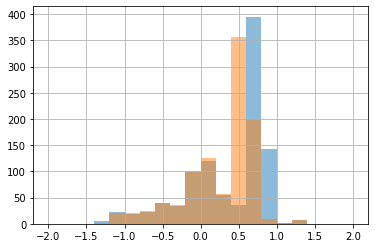

In [8]:
def loss_aversion(housing_unit):
    if housing_unit['investor type'] == 'corporate':
        return np.random.normal(1, 0.07)
    else:
        return np.random.normal(2.25, 0.1)
    
df['loss aversion coefficient'] = df.apply(loss_aversion, axis=1)

def probability_weight(housing_unit):
    if housing_unit['investor type'] == 'corporate':
        return np.random.normal(0.7, 0.01)
    else:
        return np.random.normal(0.5, 0.01)
    
df['probability gamma'] = df.apply(probability_weight, axis=1)
    

def prospect_value_rent(housing_unit, taxes=True):
    if taxes:
        outcomes = [(housing_unit['rate of return no rent tax'], 1-housing_unit['probability of rent']), 
                    (housing_unit['rate of return rent tax'], housing_unit['probability of rent'])]
    else:
        outcomes = [(housing_unit['rate of return no rent no tax'], 1-housing_unit['probability of rent']), 
                    (housing_unit['rate of return rent no tax'], housing_unit['probability of rent'])]
        
    loss_aversion = housing_unit['loss aversion coefficient']
    
    gamma = housing_unit['probability gamma']
    v = lambda x: x if x >= 0 else -loss_aversion*(-x)
    w = lambda p: (p**gamma) / (p**gamma + (1 - p)**gamma)**(1/gamma)
    
#    ptv = v(housing_unit['rate of return no rent'])*w(1-housing_unit['probability of rent']) + \
#          v(housing_unit['rate of return rent'])*w(housing_unit['probability of rent'])
    ptv = sum(map(lambda x: v(x[0])*w(x[1]), outcomes))
    return ptv

df['prospect theory value rent tax'] = df.apply(prospect_value_rent, axis=1)
df['prospect theory value rent no tax'] = df.apply(prospect_value_rent, taxes=False, axis=1)

#df['rate of return rent'].hist(alpha=0.5)
#df['rate of return no rent'].hist(alpha=0.5)
#df['loss aversion coefficient'].hist(alpha=0.5, bins=50)
df['expected value rent tax'].hist(alpha=0.5, range=[-2,2], bins=20)
df['prospect theory value rent tax'].hist(alpha=0.5, range=[-2,2], bins=20)


<AxesSubplot:>

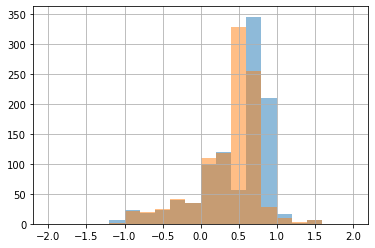

In [9]:
df['expected value rent no tax'].hist(alpha=0.5, range=[-2,2], bins=20)
df['prospect theory value rent no tax'].hist(alpha=0.5, range=[-2,2], bins=20)

# Renting with tax vs without tax 

The following graph is the key to this thesis. It shows the effect of tax on the perceived prospect of the rate of return of renting out a housing unit, with or without taxes.

<AxesSubplot:>

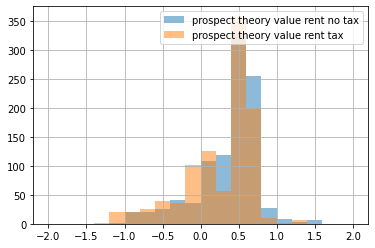

In [10]:
df['prospect theory value rent no tax'].hist(alpha=0.5, range=[-2,2], bins=20, legend=True)
df['prospect theory value rent tax'].hist(alpha=0.5, range=[-2,2], bins=20, legend=True )

# Rate of return for sale market

Let's go back to David's formula. 

$$RoR = v = \frac{V}{D} =\frac{\delta ( 1+\dot{p}-(1+r)m)+\rho -\kappa -t}{1-m}$$

With the following variables: 

variable | meaning 
-------- | -------
$\delta$ | Sujbective discount factor
$\dot{p}$ | Expected rate of price increase, $\dot{p} = \frac{P_T-P_0}{P_0}$, where $P_0$ is the initial price, and $P_T$ is the expected sale price at time T
$r$ | Interest rate on mortgages 
$m$ | Mortgage as share of price 
$\rho$ | Rent as share of price
$\kappa$ | Operating costs as share of price 
$t$ | taxes (vacancy, property, etc...)

How do we determine the subjective discount factor $\delta$? Is it different if I'm looking to sell vs if i'm looking to rent? Is it different based on the period of time that it is calculated for? 


## Let's think about the time dimension in the RoR formula

The rate of return calculation formulated as rates, which by definition include a time dimension. So, to come up with values for each of the variables, for either `sell` or `rent` prospect, we have to think of the time associated with it. 

In the `rent` case, should the rate of return be counted for the three years of the rental contract period, instead of a single time step? So if monthly rent is 0.4% of the price of the housing unit, so $\rho$ should be $0.004\times12\times3$? How is the subjective discount factor ($\delta$) affected in this calculation? Similarly for $\kappa$, $t$? Importantly, $\dot{p}$ should be calculated starting at purchase price, ending at the end of the three year rental contract. Correct?

Following the same time logic for the `sell` case, what time frame do we use for the calculation? Defining it between the purchase time and the sale time makes sense. I think. Let's try it below. 

An corporate investor has a housing unit that they would like to `sell` or `rent`. They have the following attributes: 

variable | value 
-------- | ------- 
$r$      | 7% for corporate, 9% for amateur, per year
$P_0$    | &#36;300,000 
$P_T$ (3y) | &#36;330,000  (sale price after 3 years) 
$P_T$ (1y) | &#36;310,000  (sale price after 1 years)
$M$      | &#36;250,000 for corporate, &#36;50,000 for amateur <br/>(amateur devs prefer to pre-sell, so they have smaller mortgages)
$\delta$ | 0.85 for corporate, 0.55 for amateur <br/> ($\frac{1}{1+r^s}$ ⬅️ what is s in this sitation?)
montly rent | &#36;400 
montly operating costs | &#36;50
rent period | 3 years 
vacancy tax | 0.5%, 0.005 per year
property tax | 0.1%, 0.001 per year
transfer tax | 1% (one time tax)

### How do amateur and corporate investors differ? 

When they calculate their rate of return on investments, corporate and amateur investors differ in three significant ways: 

- **Subjective discount rate**: As a measure of impatience, I assume that amateur investors are more in a rush to sell their units today instead of next year, because they have higher operating costs and interest rate. Meanwhile, corporate investors have lower operating costs, so they are less impatient, and their discount rate is highter. 
- **Loan size**: Corporate developers have more access to credit, so their loans are a larger portion of the price of the housing unit, while amateur developers rely on pre-selling units to cover costs. 
- **Interest rate**: Again, access corporate developers have access to loans with lower interest rates due to their networks and investment history. 

In addition to those, in prospect theory, we have the following attributes: 

- **Loss aversion**: Amateur investors are much more loss averse than corporate investors
- **Probability wieghing**: People tend to underweigh high probability, while overweighing low probabilities. Presumably, an investor that has more insight into the market evaluates their probabilities closer to reality than those who have less access to information. Thus, corporate investors have a higher $\lambda$ than amateur investors. 


### Questions

- What kind of access to credit do the types of developers have? This affects two parameters: interest rate, and size of loan
- Do amateur investors have a higher subjective discount factor than corporate investors? How is that number determmined? 
- Do we have to align the time resolution of the discount factor, interest rate, $P_T$, rent, operating costs, property tax, and vacancy tax? 


In [19]:
def ror(delta, p_0, p_T, M, r, rent, operating_costs, taxes):
    m = M / p_0
    rho = rent / p_0
    kappa = operating_costs / p_0
    t = sum(taxes)
    p_dot = (p_T - p_0) / p_0
#    print(f'interst = {(1+r)*m}')
#    print(f'capital gain = {1 + p_dot - (1+r)*m}')
#    print(f'rho = {rho}')
#    print(f'kappa = {kappa}')
#    print(f'tax = {t}')
#    print(f'_______________')
    v = (delta*(1 + p_dot - (1 + r)*m) + rho - kappa - t) / (1 - m)
    return  v # - 1


# buy a unit today for 300000, rent it for three years
p_0 =       300e3
p_T_rent =  310e3 # price after 3 years 
p_T_sell =  310e3 # price gain after 1 year (1 time step)
#p_T_sell = 290000 # price loss after 1 year (1 time step)
#p_T_sell = 330000 # price after 3 year (3 time steps) ---> so we can make apples to apples comparison (3 year horizon)
monthly_rent = 400
monthly_operating_costs = 50
property_tax = 0.001
vacancy_tax = 0.01
transfer_tax = 0.01 # find a good number 

# Return without operating costs, rent gains, or interest
neutral = ror(1, p_0, p_0, 0, 0, 0, 0, [])
print(f'neutral is {neutral}')


# PROFESSIONAL INVESTOR 

delta_pro = 1 # 0.85 
M = 250e3
r = 0.07


pro_ror = {
    'category' : ['professional'],
    ## RENT 
    'rent + no tax':    [ror(delta_pro, p_0, p_T_rent, M, r, monthly_rent*12, monthly_operating_costs*12, []), ],
    'no rent + no tax': [ror(delta_pro, p_0, p_T_rent, M, r, 0, monthly_operating_costs*12, []), ],
    ## SELL 
    'sell + tax':       [ror(delta_pro, p_0, p_T_sell, M, r, 0, 0, [transfer_tax, ]), ],
    'no sell + tax':    [ror(delta_pro, p_0, p_T_sell, M, r, 0, monthly_operating_costs*12, [property_tax, vacancy_tax]), ],
    'sell + no tax':    [ror(delta_pro, p_0, p_T_sell, M, r, 0, 0, [transfer_tax, ]), ],
    'no sell + no tax': [ror(delta_pro, p_0, p_T_sell, M, r, 0, monthly_operating_costs*12, []), ],
}

rors = pd.DataFrame(pro_ror)

# AMATEUR INVESTOR
delta_amateur = 1 # 0.75
M = 150e3
r = 0.09


amateur_ror = {
    'category' : 'amateur',
    ## RENT
    'rent + tax':       ror(delta_amateur, p_0, p_T_rent, M, r, monthly_rent*12, monthly_operating_costs*12, [property_tax, vacancy_tax]),
    'no rent + tax':    ror(delta_amateur, p_0, p_T_rent, M, r, 0, monthly_operating_costs*12, [property_tax, vacancy_tax]),
    'rent + no tax':    ror(delta_amateur, p_0, p_T_rent, M, r, monthly_rent*12, monthly_operating_costs*12, []),
    'no rent + no tax': ror(delta_amateur, p_0, p_T_rent, M, r, 0, monthly_operating_costs*12, []),
    ## SELL 
    'sell + tax':       ror(delta_pro, p_0, p_T_sell, M, r, 0, 0, [transfer_tax, ]),
    'no sell + tax':    ror(delta_pro, p_0, p_T_sell, M, r, 0, monthly_operating_costs*12, [property_tax, vacancy_tax]),
    'sell + no tax':    ror(delta_pro, p_0, p_T_sell, M, r, 0, 0, [transfer_tax, ]),
    'no sell + no tax': ror(delta_pro, p_0, p_T_sell, M, r, 0, monthly_operating_costs*12, []),
}

rors = rors.append(amateur_ror, ignore_index=True)

# rors.T


ror_tax = {
    
    'rent': [ror(delta_pro, p_0, p_T_rent, M, r, monthly_rent*12, monthly_operating_costs*12, [property_tax, vacancy_tax]), ],
    'sell': [ror(delta_pro, p_0, p_T_sell, M, r, 0, 0, [transfer_tax, ]), ],
    'wait': [ror(delta_pro, p_0, p_T_rent, M, r, 0, monthly_operating_costs*12, [property_tax, vacancy_tax]), ],
} 

# rent
"""
monthly_rent*12
monthly_operating_costs*12
[property_tax]
"""
# sell
"""
0
0
[transfer_tax]
"""
# wait
"""
0
monthly_operating_costs*12
[property_tax, vacancy_tax]
"""

pd.DataFrame(ror_tax).T


neutral is 1.0


0
rent  0.982667
sell  0.956667
wait  0.950667

# Price bargaining 

Use the Kalai-Smnorodisky solution, which is built using four different values: 

- Owner's highest
- Owner's lowest 
- Buyer/reneter's highest 
- Buyer/reneter's lowest 

Let's try it out with some numbers. 

$$PTV_{rent} = w(p_{wait}) v(x_{wait})+
w(p_{rent}) v(x_{rent})$$


In [1]:
price_neighbourhood_avg = 300e3

seller_optimism_factor = 1.20
seller_pessimism_factor = 0.95

buyer_budget_housing = 290e3
buyer_pessimism_factor = 1.10
buyer_optimism_factor = 0.95

# owner highest 
oh = price_neighbourhood_avg*seller_optimism_factor
# owner lowest 
ol = price_neighbourhood_avg*seller_pessimism_factor

# buyer highest 
bh = buyer_budget_housing*buyer_pessimism_factor
bl = buyer_budget_housing*buyer_optimism_factor


def bargain(oh, ol, bh, bl):
    return ol + ((oh-ol)/(oh-ol+bh-bl))*(oh-ol)

bargain(oh,ol,bh,bl)



332468.35443037975

## Let's try some pandas dataframes 


In [4]:
import numpy as np
import pandas as pd
import geopandas as gpd
import random 


df = pd.DataFrame(columns=['investor id', 'gamma', 'lambda', 'discount factor', 'interest rate', 'mortgage share', 
                           'operating costs', 'taxes', 
                           'asking price rent', 'asking price sale', 'area', 'neighbourhood', 
                           'ror sale', 'ror rent', 'ror wait', 
                           'prob sale', 'prob rent',
                           'ptv sale', 'ptv rent', 'ptv wait',])

df.head()

Empty DataFrame
Columns: [investor id, gamma, lambda, discount factor, interest rate, mortgage share, operating costs, taxes, asking price rent, asking price sale, area, neighbourhood, ror sale, ror rent, ror wait, prob sale, prob rent, ptv sale, ptv rent, ptv wait]
Index: []